# INFO 602 Final Project - InfoSec Open Source Intelligence (OSINT) Categorization
Michael Poff

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from IPython.display import display, Markdown

## Data

In [3]:
data = pd.read_csv('C:/Users/poffm/OneDrive/School/Calvin/INFO 602/FinalProject/data/article_data.csv')
display (Markdown(f"The dataset contains {len(data)} data points, each of which represents an article scraped from a number of information security news and intelligence providers (listed below). Each row contains the following features:"))

The dataset contains 170 data points, each of which represents an article scraped from a number of information security news and intelligence providers (listed below). Each row contains the following features:

-   Title: The title of the article.
-   Content: The article contents.
-   Category: A manually labeled category label, chosen from one of nine options (listed below).
-   Zero-Shot Category: A label applied by the [HuggingFace zero-shot classification transformer](https://huggingface.co/tasks/zero-shot-classification) using the same set of nine options.
-   Zero-Shot Match: Indicates whether the zero-shot classification corresponds with the manual category assignment, expressed as TRUE or FALSE.

**Categories:**
-   Vulnerability Reports: Specific vulnerabilities found in software or hardware.
-   Security Updates and Patches: Latest releases of security patches and updates.
-   Emerging Threats and Attack Techniques: New cyber threats and attack methods.
-   Regulatory Changes and Compliance: Updates to cybersecurity laws and regulations.
-   Data Breaches and Security Incidents: Reports and analyses of recent data breaches or security incidents.
-   News and Industry Updates: General security news.
-   Marketing: Content primarily meant to highlight, advertise, or market a security product.

**Sources:**
-   [The Hacker News](https://thehackernews.com/)
-   [Bleeping Computer](https://www.bleepingcomputer.com/)
-   [Dark Reading](https://www.darkreading.com/)
-   [CISA Advisories](https://www.cisa.gov/news-events/cybersecurity-advisories)
-   [The Register - Security](https://www.theregister.com/security/)

The title and article data were scraped using the Python library [Trafilatura](https://github.com/adbar/trafilatura) which does a good job of scraping content and metadata from article web pages, however some results are skewed. Rather than manually refine the data, the model should learn to ignore this extraneous text.

## Exploratory Data Analysis

### Data Preview
First, a quick look at a row of data. This is limited to a single row because the contents are quite large.

In [4]:
data.head(1).style.set_properties(**{'background-color': 'black', 
                                   'color': 'white', 
                                   'border-color': 'gray'})

,title,content,category,zero-shot category,zero-shot match
0,CISA Warns of Active Exploitation Apple iOS and macOS Vulnerability,"The U.S. Cybersecurity and Infrastructure Security Agency (CISA) on Wednesday added a high-severity flaw impacting iOS, iPadOS, macOS, tvOS, and watchOS to its Known Exploited Vulnerabilities (KEV) catalog, based on evidence of active exploitation.The vulnerability, tracked as CVE-2022-48618 (CVSS score: 7.8), concerns a bug in the kernel component.""An attacker with arbitrary read and write capability may be able to bypass Pointer Authentication,"" Apple said in an advisory, adding the issue ""may have been exploited against versions of iOS released before iOS 15.7.1.""The iPhone maker said the problem was addressed with improved checks. It's currently not known how the vulnerability is being weaponized in real-world attacks.Interestingly, patches for the flaw were released on December 13, 2022, with the release of iOS 16.2, iPadOS 16.2, macOS Ventura 13.1, tvOS 16.2, and watchOS 9.2, although it was only publicly disclosed more than a year later on January 9, 2024.It's worth noting that Apple did resolve a similar flaw in the kernel (CVE-2022-32844, CVSS score: 6.3) in iOS 15.6 and iPadOS 15.6, which was shipped on July 20, 2022. It's not immediately clear if the two vulnerabilities are related.""An app with arbitrary kernel read and write capability may be able to bypass Pointer Authentication,"" the company said at the time. ""A logic issue was addressed with improved state management.""In light of the active exploitation of CVE-2022-48618, CISA is recommending that Federal Civilian Executive Branch (FCEB) agencies apply the fixes by February 21, 2024.The development also comes as Apple expanded patches for an actively exploited security flaw in the WebKit browser engine (CVE-2024-23222, CVSS score: 8.8) to include its Apple Vision Pro headset. The fix is available in visionOS 1.0.2.",vulnerability reports,security updates and patches,False


### Categories
This is a simple count of how many articles there are per category.

In [5]:
data['category'].value_counts().reset_index()

,category,count
0,news and industry updates,83
1,emerging threats and attack techniques,29
2,vulnerability reports,22
3,data breaches and security incidents,14
4,marketing,13
5,security updates and patches,7
6,regulatory changes and compliance,2


The low count of regulatory change and compliance articles may mean I need to remove the category altogether or pull more articles manually to fill out that category and provide enough data for training and testing.

### Zero-Shot vs. Manual Classification
This section demonstrates the effectiveness of zero-shot classification versus manual classification.


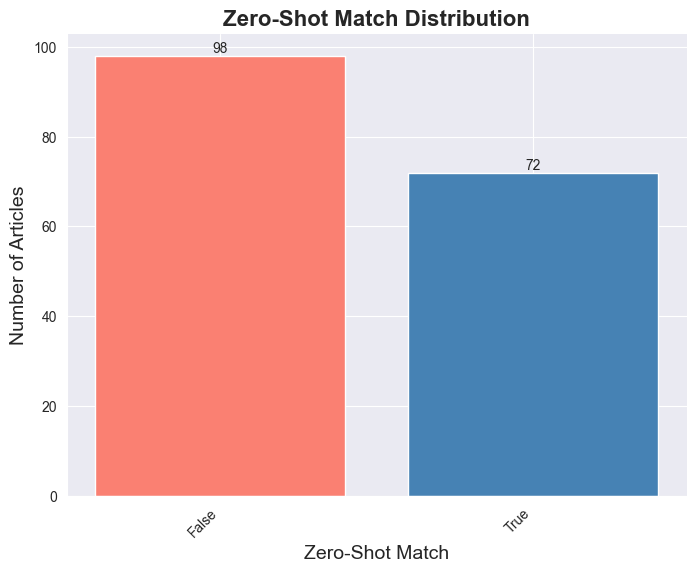

In [23]:
data['zero-shot match'] = data['zero-shot match'].astype(str)
grouped_data = data.groupby('zero-shot match').size().reset_index(name='n')

colors = ['steelblue' if x == 'True' else 'salmon' for x in grouped_data['zero-shot match']]

# Creating the plot
plt.figure(figsize=(8, 6))
bars = plt.bar(grouped_data['zero-shot match'], grouped_data['n'], color=colors)

# Adding text labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

# Customizing the plot
plt.title('Zero-Shot Match Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Zero-Shot Match', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.xticks(rotation=45, ha='right')
sns.despine()

# Show plot
plt.show()

This plot demonstrates that zero-shot classification correctly classifies articles 42% of the time. This is a good benchmark for our model to compare against a deep neural network with a generalized task.

### Word Clouds
These word clouds distill the core themes across different cybersecurity categories, highlighting key terms. They offer a quick visual summary of the most discussed topics in the field.

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\poffm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\poffm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


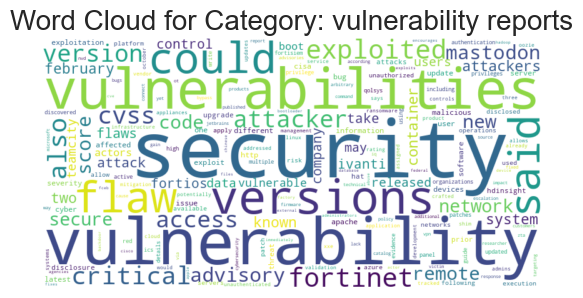

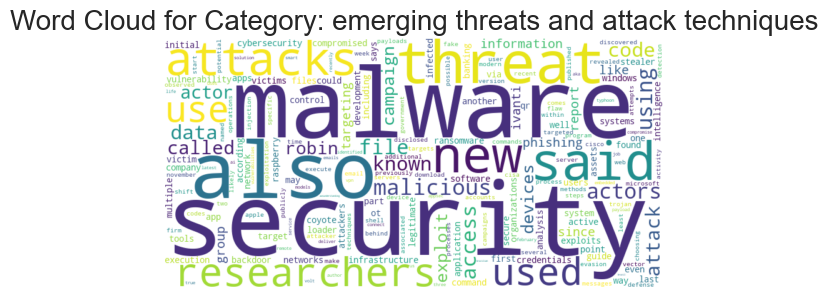

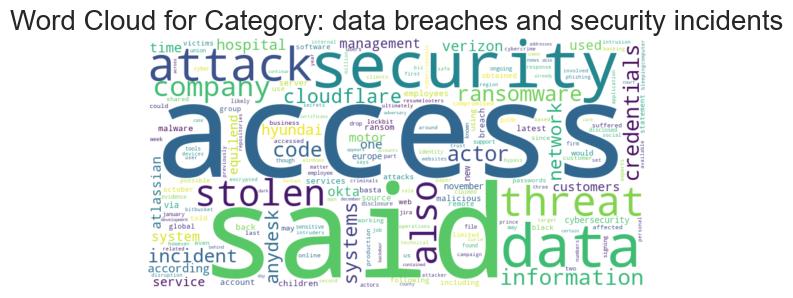

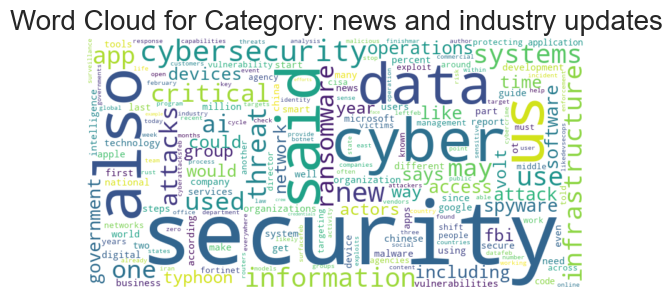

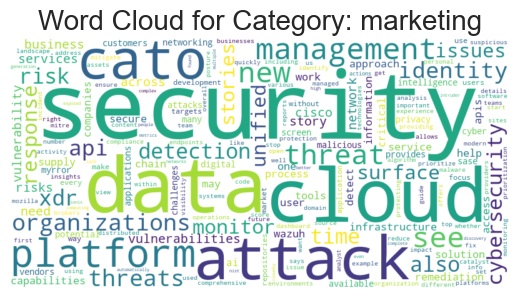

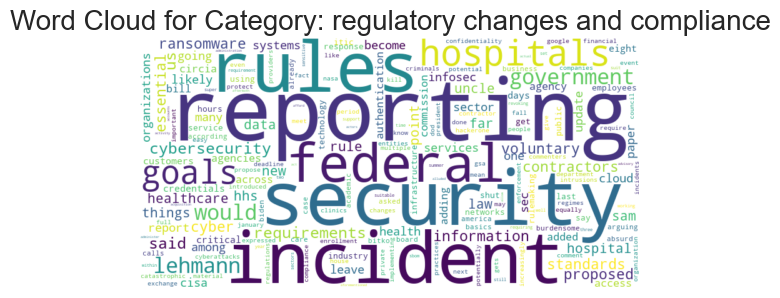

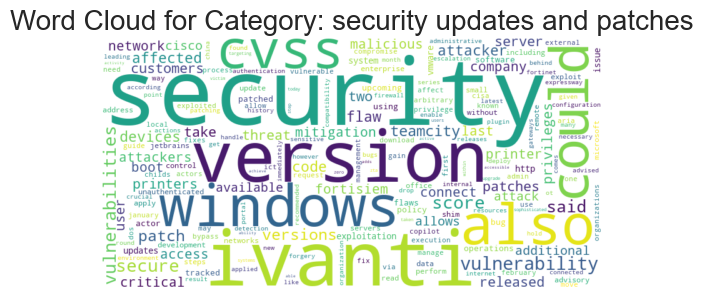

In [30]:
# Ensure you've downloaded the stop words through nltk
nltk.download('punkt')
nltk.download('stopwords')

# Assuming 'data' is your DataFrame and it contains 'content' and 'category' columns
# Tokenize the content and remove stop words
stop_words = set(stopwords.words('english'))

# Function to clean and tokenize text
def clean_tokenize(text):
    # Tokenize and remove punctuation
    tokens = word_tokenize(text)
    # Remove non-alphabetic characters and stop words, lowercasing the words
    words = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return words

# Apply the function to each content
data['words'] = data['content'].apply(clean_tokenize)

# Expand the list of words into a new row for each word
data_clean = data.explode('words').rename(columns={'words': 'word'})
data_clean = data_clean[data_clean['word'] != ""]  # Remove empty words

# Calculate word frequencies by category
word_frequencies_by_category = data_clean.groupby(['category', 'word']).size().reset_index(name='n')

# Iterate through each unique category to generate word clouds
for category in data_clean['category'].unique():
    # Filter data for the current category
    cat_data = word_frequencies_by_category[word_frequencies_by_category['category'] == category]
    
    # Generate a word cloud
    wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate_from_frequencies(dict(zip(cat_data['word'], cat_data['n'])))
    
    # Plotting the WordCloud                    
    plt.figure(figsize = (5, 2.5), facecolor = None) 
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad = 0) 
    
    plt.title(f'Word Cloud for Category: {category}', fontsize=20)
    plt.show()